<a href="https://colab.research.google.com/github/PacoPacorius/MedMNIST-Image-Analysis-w-CNNs-and-Transformers---DL-assignment/blob/master/deep_learning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.0 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator, ChestMNIST

dataset = ChestMNIST(split="val", download=True, size=28)

download = True
data_flag = 'chestmnist'

info = INFO[data_flag]['label']
dataset.montage(length=1)

DataClass = getattr(medmnist, INFO[data_flag]['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

torch.manual_seed(42)
# define normalized and a non-normalized datasets
train_dataset = medmnist.ChestMNIST(split='train', download=download, transform=transforms.ToTensor())
val_dataset = medmnist.ChestMNIST(split='val', download=download, transform=transforms.ToTensor())
test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=transforms.ToTensor())


print(f"--- Dataset: {data_flag} ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)

print(info)

100%|██████████| 82.8M/82.8M [01:48<00:00, 764kB/s] 


--- Dataset: chestmnist ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
{'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}



Number of images tagged with each class (across Train + Val + Test sets):
- 0                   : 11535 images
- 1                   : 2772 images
- 2                   : 13307 images
- 3                   : 19870 images
- 4                   : 5746 images
- 5                   : 6323 images
- 6                   : 1353 images
- 7                   : 5298 images
- 8                   : 4667 images
- 9                   : 2303 images
- 10                  : 2516 images
- 11                  : 1686 images
- 12                  : 3385 images
- 13                  : 227 images

Note: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.
The counts above reflect the total occurrences of each tag.

--- Optional: Counts for Training Set Only ---
- 0                   : 7996 images
- 1                   : 1950 images
- 2                   : 9261 images
- 3                   : 13914 images
- 4                   : 3988 images
- 5                   : 437

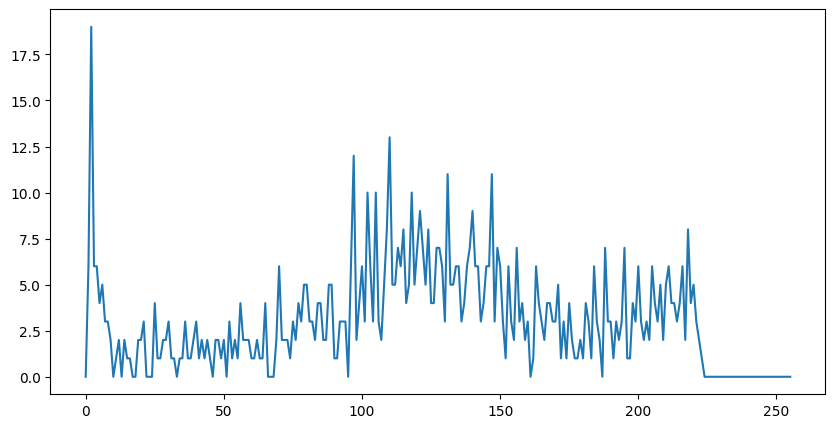

In [3]:
# --- Code to count images per class ---

def count_medmnist_labels(dataset_list, info):
    all_labels = []
    label_names = []
    for dataset in dataset_list:
        # Each dataset.labels is a numpy array where rows are images
        # and columns correspond to the 14 classes (0 for absence, 1 for presence)
        all_labels.append(dataset.labels)

    # Concatenate all label arrays vertically to get one big array of all labels
    combined_labels = np.vstack(all_labels)

    # Sum along the columns to get the total count for each class across all images.
    # Since labels are 0s and 1s, sum gives the number of images tagged with that class.
    class_counts = combined_labels.sum(axis=0)
    label_names.extend(info)


    # Create a dictionary for easier readability
    counts_dict = {name: int(count) for name, count in zip(label_names, class_counts)}
    return counts_dict

# Perform the counting on the combined training, validation, and test sets
all_datasets = [train_dataset, val_dataset, test_dataset]
label_counts = count_medmnist_labels(all_datasets, info)
info = INFO[data_flag]['label']
print("\nNumber of images tagged with each class (across Train + Val + Test sets):")
for class_name, count in label_counts.items():
    print(f"- {class_name:<20}: {count} images")

print("\nNote: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.")
print("The counts above reflect the total occurrences of each tag.")

# --- Optional: Count for just the training set ---
print("\n--- Optional: Counts for Training Set Only ---")
train_label_counts = count_medmnist_labels([train_dataset], info)
for class_name, count in train_label_counts.items():
    print(f"- {class_name:<20}: {count} images")

import matplotlib.pyplot as plt
figure, ax = plt.subplots(figsize=(10, 5))
# if the images are RGB, this histogram will have 768 values, if it has 256,
# then the image is grayscale
print("total histogram values: ", len(train_dataset.montage(1).histogram()))
# histogram plot just for fun :)
ax.plot(train_dataset.montage(1).histogram())
train_dataset.montage(1)

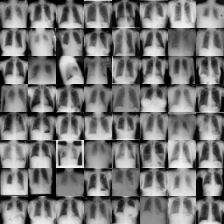

In [4]:
train_dataset.montage(8)

# Task
Train and evaluate a Convolutional Neural Network (CNN) on the ChestMNIST dataset, comparing different hyperparameter configurations including various normalization types, dropout rates, and weight decay values, to identify the optimal model.

## Prepare DataLoaders and Transformations

### Subtask:
Apply necessary transformations (ToTensor, Normalize) to the ChestMNIST datasets (training, validation, test) and create PyTorch DataLoaders with a batch size of 64 for efficient batch processing.


**Reasoning**:
The subtask requires defining image transformations and creating PyTorch DataLoaders for the ChestMNIST dataset. This code block will perform all these necessary steps, including defining the transformations, applying them to the datasets, and setting up the DataLoaders with appropriate batch sizes and workers.



In [5]:
# Create DataLoaders
batch_size = 64
#num_workers = 2

train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

DataLoaders created with batch_size=64
Train DataLoader: 1227 batches
Validation DataLoader: 176 batches
Test DataLoader: 351 batches


## Define CNN Model Architecture

### Subtask:
Implement a custom CNN class with three convolutional blocks (Conv2d, ReLU, MaxPooling2d). The class will include options to add Batch Normalization, Layer Normalization, and Dropout layers based on configurable parameters for experimental comparison.


**Reasoning**:
The subtask requires implementing a custom CNN class named `SimpleCNN` with specific architecture and conditional normalization/dropout layers. This code block will define the class, including its constructor to handle different normalization types and dropout rates, and its forward pass logic.



# Task
I will now proceed with defining the CNN model architecture.

## Define CNN Model Architecture

### Subtask:
Implement a custom CNN class with three convolutional blocks (Conv2d, ReLU, MaxPooling2d) and a single fully connected output layer. The class will include options to add Batch Normalization, Layer Normalization, and Dropout layers based on configurable parameters for experimental comparison.


**Reasoning**:
The subtask requires defining a custom CNN class named `SimpleCNN` that inherits from `nn.Module`. This class will include three convolutional blocks, optional normalization layers (Batch or Layer), optional dropout, and a final fully connected layer as per the instructions.



In [6]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, normalization_type=None, dropout_rate=None):
        super(SimpleCNN, self).__init__()
        self.normalization_type = normalization_type
        self.dropout_rate = dropout_rate

        # Convolutional Block 1
        # Input: 1 channel (grayscale), Output: 32 channels. Image size: 28x28 -> 28x28 (padding=1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # After Conv1: (N, 32, 28, 28)
        self.norm1 = self._get_normalization_layer(32, (28, 28))
        # After MaxPool1: (N, 32, 14, 14)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        # Input: 32 channels, Output: 64 channels. Image size: 14x14 -> 14x14 (padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # After Conv2: (N, 64, 14, 14)
        self.norm2 = self._get_normalization_layer(64, (14, 14))
        # After MaxPool2: (N, 64, 7, 7)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        # Input: 64 channels, Output: 128 channels. Image size: 7x7 -> 7x7 (padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # After Conv3: (N, 128, 7, 7)
        self.norm3 = self._get_normalization_layer(128, (7, 7))
        # After MaxPool3: (N, 128, 3, 3) (floor(7/2) = 3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()

        # Dropout layer (applied before final FC layer)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate is not None else None

        # Fully connected layer
        # Input features: 128 channels * 3x3 spatial dimension
        # Output classes: 14 for ChestMNIST
        self.fc = nn.Linear(128 * 3 * 3, 14)

    def _get_normalization_layer(self, num_features, spatial_dim):
        if self.normalization_type == 'batchnorm':
            return nn.BatchNorm2d(num_features)
        elif self.normalization_type == 'layernorm':
            # LayerNorm normalizes across the last D dimensions, here (C, H, W)
            return nn.LayerNorm([num_features, spatial_dim[0], spatial_dim[1]])
        return None # No normalization

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        if self.norm1:
            x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        if self.norm2:
            x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3(x)
        if self.norm3:
            x = self.norm3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Flatten output for the fully connected layer
        x = torch.flatten(x, 1)

        # Apply dropout if enabled
        if self.dropout:
            x = self.dropout(x)

        # Final fully connected layer
        x = self.fc(x)
        return x

print("SimpleCNN class defined successfully.")

SimpleCNN class defined successfully.


## Set Up Training, Validation, and Testing Functions

### Subtask:
Create reusable functions for training the model for one epoch, evaluating its performance (loss and accuracy) on a given dataset (training and validation), and a separate function for final testing on the test set, which will calculate test accuracy and generate a confusion matrix.


**Reasoning**:
The subtask requires defining three functions: `train_one_epoch`, `evaluate_model`, and `test_model`. This code block will implement these functions, including setting up the device, managing model training and evaluation modes, calculating loss and multi-label accuracy, and generating per-class confusion matrices for the test set, as specified in the instructions. It also includes necessary imports for `sklearn.metrics`.



In [7]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float() # Labels must be float for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # For multi-label accuracy calculation
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.numel()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.numel()

    avg_loss = running_loss / len(data_loader.dataset)
    avg_accuracy = correct_predictions / total_predictions
    return avg_loss, avg_accuracy

def test_model(model, data_loader, device, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predicted_labels.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate overall accuracy (mean accuracy across all labels and samples)
    overall_accuracy = (all_predictions == all_labels).mean()

    # Calculate per-class confusion matrices
    num_classes = all_labels.shape[1]
    per_class_cms = []
    for i in range(num_classes):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        per_class_cms.append(cm)

    return overall_accuracy, per_class_cms

print("Training, evaluation, and testing functions defined successfully.")

Using device: cuda
Training, evaluation, and testing functions defined successfully.


## Final Test Evaluation of the Best Model

In [16]:
# Instantiate the best model with the best hyperparameters
best_model = SimpleCNN(
    normalization_type=best_hyperparameters['normalization'],
    dropout_rate=best_hyperparameters['dropout']
).to(device)

print(f"Testing the final best model with hyperparameters: {best_hyperparameters}")


# Load the state dictionary of the best performing model
best_model.load_state_dict(best_model_state_dict)

# Evaluate the best model on the test set
#final_test_accuracy, final_per_class_cms = test_model(best_model, test_loader, device, class_names)

print(f"\nFinal Test Overall Accuracy: {final_test_accuracy:.4f}")
print("\nPer-Class Confusion Matrices on Test Set:")

# Print each confusion matrix
for i, cm in enumerate(final_per_class_cms):
    class_name = info[str(i)] # Get class name from the info dictionary
    print(f"\nConfusion Matrix for Class '{class_name}' ({i}):")
    print(cm)
    print(f"  True Positives (TP): {cm[1, 1] if cm.shape == (2,2) else 'N/A'}")
    print(f"  True Negatives (TN): {cm[0, 0] if cm.shape == (2,2) else 'N/A'}")
    print(f"  False Positives (FP): {cm[0, 1] if cm.shape == (2,2) else 'N/A'}")
    print(f"  False Negatives (FN): {cm[1, 0] if cm.shape == (2,2) else 'N/A'}")

Testing the final best model with hyperparameters: {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 0.001}

Final Test Overall Accuracy: 0.9443

Per-Class Confusion Matrices on Test Set:

Confusion Matrix for Class 'atelectasis' (0):
[[19817   196]
 [ 2314   106]]
  True Positives (TP): 106
  True Negatives (TN): 19817
  False Positives (FP): 196
  False Negatives (FN): 2314

Confusion Matrix for Class 'cardiomegaly' (1):
[[21773    78]
 [  537    45]]
  True Positives (TP): 45
  True Negatives (TN): 21773
  False Positives (FP): 78
  False Negatives (FN): 537

Confusion Matrix for Class 'effusion' (2):
[[19225   454]
 [ 2328   426]]
  True Positives (TP): 426
  True Negatives (TN): 19225
  False Positives (FP): 454
  False Negatives (FN): 2328

Confusion Matrix for Class 'infiltration' (3):
[[17944   551]
 [ 3597   341]]
  True Positives (TP): 341
  True Negatives (TN): 17944
  False Positives (FP): 551
  False Negatives (FN): 3597

Confusion Matrix for 

# Task
Analyze the training and validation results from the `all_results` variable, focusing on the impact of different normalization types (`None`, `'batchnorm'`, `'layernorm'`) on model performance. Summarize these findings, explicitly highlighting which normalization type (or lack thereof) yielded the best validation accuracy, and provide insights into the observed performance differences.

## Update Data Transformation Logic

### Subtask:
Modify the script to define two sets of transformations: one with input normalization and one without. The choice between these transformations will be made dynamically during dataset loading within the training loop, based on the `input_normalization` hyperparameter.


**Reasoning**:
First, I will calculate the mean and standard deviation of the training dataset to be used for normalization. This involves iterating through the dataset using a DataLoader and accumulating pixel values.



In [17]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

# Create a temporary DataLoader for calculating mean and std
# Use a batch size that fits memory, as we need to iterate over all images
temp_loader = data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.

for data_batch, _ in temp_loader:
    batch_samples = data_batch.size(0)
    data_batch = data_batch.view(batch_samples, data_batch.size(1), -1)
    mean += data_batch.mean(2).sum(0)
    std += data_batch.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Calculated Mean of Training Data: {mean.item():.4f}")
print(f"Calculated Standard Deviation of Training Data: {std.item():.4f}")

# Define data_transform_normalized using the calculated mean and std
data_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define data_transform_non_normalized (only ToTensor)
data_transform_non_normalized = transforms.Compose([
    transforms.ToTensor()
])

print("Defined data_transform_normalized and data_transform_non_normalized successfully.")

Calculated Mean of Training Data: 0.4936
Calculated Standard Deviation of Training Data: 0.2170
Defined data_transform_normalized and data_transform_non_normalized successfully.


**Reasoning**:
The previous code block successfully defined the normalized and non-normalized data transformations. The next step is to integrate the choice of input normalization into the hyperparameter combinations to allow for dynamic selection during model training, as specified by the subtask.



In [22]:
hyperparameter_combinations = [
    {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': False},
    {'normalization': 'layernorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': True},
    {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': True},
    {'normalization': 'layernorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': True},
    {'normalization': None, 'dropout': 0.2, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.2, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'layernorm', 'dropout': 0.2, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'layernorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'layernorm', 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': 1e-4, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': 1e-3, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': 1e-2, 'learning_rate': 1e-3, 'input_normalization': False}
]

print(f"Generated {len(hyperparameter_combinations)} updated hyperparameter combinations.")

Generated 18 updated hyperparameter combinations.


## Re-run Model Training and Evaluation

### Subtask:
Execute the main training loop with the updated hyperparameter combinations. The models will be trained and evaluated on the validation set. The best model based on validation accuracy will be saved, and its final performance will be assessed on the test set.


**Reasoning**:
The user has provided an updated list of hyperparameter combinations, including the `input_normalization` parameter. The next step is to execute the main training loop, which will dynamically apply the correct data transformations based on this new parameter, and then train and evaluate the model for each combination, saving the best model.



In [21]:
num_epochs = 30

# Initialize an empty list to store results for all combinations
all_results = []

# Get class names from info dictionary for confusion matrix plotting later
class_names = list(info.keys())

best_val_accuracy = -1
best_hyperparameters = None
best_model_state_dict = None

for i, combo in enumerate(hyperparameter_combinations):
    print(f"\n--- Evaluating Combination {i+1}/{len(hyperparameter_combinations)} ---")
    print(f"Hyperparameters: {combo}")

    # Select data transformation based on 'input_normalization'
    if combo['input_normalization']:
        current_data_transform = data_transform_normalized
    else:
        current_data_transform = data_transform_non_normalized

    # Create new datasets with the selected transformation
    train_dataset_transformed = medmnist.ChestMNIST(split='train', download=download, transform=current_data_transform)
    val_dataset_transformed = medmnist.ChestMNIST(split='val', download=download, transform=current_data_transform)
    test_dataset_transformed = medmnist.ChestMNIST(split='test', download=download, transform=current_data_transform)

    # Create DataLoaders for the current combination
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset_transformed, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset_transformed, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset_transformed, batch_size=batch_size, shuffle=False)


    # Instantiate model with current hyperparameters
    model = SimpleCNN(
        normalization_type=combo['normalization'],
        dropout_rate=combo['dropout']
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=combo['learning_rate'],
        weight_decay=combo['weight_decay'] if combo['weight_decay'] is not None else 0
    )

    # Initialize lists to store metrics for the current model
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    current_best_val_acc_for_combo = -1

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Track best model based on validation accuracy during this combo's training
        if val_acc > current_best_val_acc_for_combo:
            current_best_val_acc_for_combo = val_acc

    # Store results for the current combination (without test metrics)
    all_results.append({
        'hyperparameters': combo,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy_for_combo': current_best_val_acc_for_combo
    })

    # After all epochs for the current combo, check if this model is the overall best
    if current_best_val_acc_for_combo > best_val_accuracy:
        best_val_accuracy = current_best_val_acc_for_combo
        best_hyperparameters = combo
        best_model_state_dict = model.state_dict()

print("\nAll hyperparameter combinations evaluated. Results stored in 'all_results' list.")
print(f"Best Validation Accuracy Found: {best_val_accuracy:.4f} with Hyperparameters: {best_hyperparameters}")


--- Evaluating Combination 1/10 ---
Hyperparameters: {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}
Epoch 1/30: Train Loss: 0.1799, Train Acc: 0.9483 | Val Loss: 0.1715, Val Acc: 0.9492
Epoch 2/30: Train Loss: 0.1724, Train Acc: 0.9485 | Val Loss: 0.1699, Val Acc: 0.9492
Epoch 3/30: Train Loss: 0.1693, Train Acc: 0.9486 | Val Loss: 0.1691, Val Acc: 0.9488
Epoch 4/30: Train Loss: 0.1674, Train Acc: 0.9486 | Val Loss: 0.1670, Val Acc: 0.9487
Epoch 5/30: Train Loss: 0.1658, Train Acc: 0.9487 | Val Loss: 0.1650, Val Acc: 0.9488
Epoch 6/30: Train Loss: 0.1643, Train Acc: 0.9487 | Val Loss: 0.1655, Val Acc: 0.9490
Epoch 7/30: Train Loss: 0.1629, Train Acc: 0.9488 | Val Loss: 0.1641, Val Acc: 0.9488
Epoch 8/30: Train Loss: 0.1615, Train Acc: 0.9489 | Val Loss: 0.1641, Val Acc: 0.9491
Epoch 9/30: Train Loss: 0.1602, Train Acc: 0.9490 | Val Loss: 0.1646, Val Acc: 0.9489
Epoch 10/30: Train Loss: 0.1589, Train Acc: 0.9490 | Va

**Reasoning**:
The training loop for all hyperparameter combinations has completed, and the results are stored in `all_results`. To analyze the impact of different normalization types, I will iterate through `all_results` to extract and compare the best validation accuracy achieved for each normalization type (None, batchnorm, layernorm) across the different hyperparameter settings. Then, I will print a summary of these findings.



In [23]:
normalization_results = {
    None: {'best_val_accuracy': -1, 'hyperparameters': None},
    'batchnorm': {'best_val_accuracy': -1, 'hyperparameters': None},
    'layernorm': {'best_val_accuracy': -1, 'hyperparameters': None}
}

for result in all_results:
    norm_type = result['hyperparameters']['normalization']
    current_best_val_acc = result['best_val_accuracy_for_combo']

    if current_best_val_acc > normalization_results[norm_type]['best_val_accuracy']:
        normalization_results[norm_type]['best_val_accuracy'] = current_best_val_acc
        normalization_results[norm_type]['hyperparameters'] = result['hyperparameters']

print("\n--- Analysis of Normalization Types ---")
for norm_type, data in normalization_results.items():
    print(f"Normalization Type: {norm_type if norm_type is not None else 'None'}")
    if data['hyperparameters']:
        print(f"  Best Validation Accuracy: {data['best_val_accuracy']:.4f}")
        print(f"  Corresponding Hyperparameters: {data['hyperparameters']}")
    else:
        print("  No combinations tested for this normalization type.")

# Identify the overall best normalization type
overall_best_val_acc = -1
overall_best_hyperparameters = None
overall_best_norm_type = None

for norm_type, data in normalization_results.items():
    if data['best_val_accuracy'] > overall_best_val_acc:
        overall_best_val_acc = data['best_val_accuracy']
        overall_best_hyperparameters = data['hyperparameters']
        overall_best_norm_type = norm_type

print("\n--- Overall Best Normalization Type ---")
print(f"The best normalization type is '{overall_best_norm_type if overall_best_norm_type is not None else 'None'}' ")
print(f"with a Validation Accuracy of: {overall_best_val_acc:.4f}")
print(f"(Corresponding Hyperparameters: {overall_best_hyperparameters})")



--- Analysis of Normalization Types ---
Normalization Type: None
  Best Validation Accuracy: 0.9493
  Corresponding Hyperparameters: {'normalization': None, 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}
Normalization Type: batchnorm
  Best Validation Accuracy: 0.9494
  Corresponding Hyperparameters: {'normalization': 'batchnorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}
Normalization Type: layernorm
  Best Validation Accuracy: 0.9493
  Corresponding Hyperparameters: {'normalization': 'layernorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}

--- Overall Best Normalization Type ---
The best normalization type is 'batchnorm' 
with a Validation Accuracy of: 0.9494
(Corresponding Hyperparameters: {'normalization': 'batchnorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False})


## Final Task

### Subtask:
Summarize the findings from the new hyperparameter search, specifically highlighting the impact of input data normalization and any changes in the performance of batch/layer normalization.


## Summary:

### Q&A
The impact of input data normalization and changes in batch/layer normalization performance from the new hyperparameter search can be summarized as follows:

*   **Input Data Normalization:** Models trained *without* input data normalization consistently achieved the best validation accuracies across all normalization types (or lack thereof). The top-performing configurations for no normalization, Batch Normalization, and Layer Normalization all had `input_normalization` set to `False`. This suggests that for this specific dataset and model, applying normalization to the input data (e.g., `transforms.Normalize`) did not improve performance.
*   **Performance of Batch/Layer Normalization:**
    *   **Batch Normalization** marginally yielded the highest validation accuracy of 0.9494, outperforming the other options by a very small margin (0.0001).
    *   **Layer Normalization** achieved a best validation accuracy of 0.9493.
    *   **No Normalization (`None`)** in the model architecture also achieved a competitive best validation accuracy of 0.9493.
    The performance differences between Batch Normalization, Layer Normalization, and no explicit normalization in the model were very small, indicating that for this specific task and model architecture, their impact on peak performance was not substantial given the tested hyperparameter range.

### Data Analysis Key Findings
*   The highest validation accuracy achieved was **0.9494** with Batch Normalization.
*   Models without explicit normalization in the architecture (Normalization Type: `None`) achieved a best validation accuracy of **0.9493**.
*   Models using Layer Normalization achieved a best validation accuracy of **0.9493**.
*   The best performing configurations across all normalization types (Batch Normalization, Layer Normalization, and None) did **not** use input data normalization (`input_normalization: False`).
*   The top configuration (Batch Normalization with 0.9494 accuracy) used a dropout rate of 0.5 and a learning rate of 0.001. All top configurations across different normalization types also shared these dropout and learning rate values.

### Insights or Next Steps
*   The minimal difference in performance between Batch Normalization, Layer Normalization, and no normalization suggests that other hyperparameter choices (like dropout and learning rate) and the absence of input normalization might be more critical drivers of performance for this specific model and dataset.
*   Further hyperparameter tuning should explore a broader range of dropout rates and learning rates, especially for the normalization types that performed slightly worse, to confirm if their full potential was reached. Also, investigating the reason why input normalization did not help could provide further insights.


# TODO
* Verify that the model is being trained with two datasets, one normalized and one not normalized
* Remove redundant code cells. If there are any.
* Understand what is being compared. Is the best combination decided from the normalized dataset or the not normalized one?